In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from langdetect import detect

plt.style.use('ggplot')

In [2]:
def Remove1(txt):
    # Apply lowercasing
    txt = str(txt).lower()
    # Remove mentions
    txt = re.sub(r'@[A-Za-z0-9_]+', '', txt)
    # Remove hashtags
    txt = re.sub(r'#', '', txt)
    # Remove retweets:
    txt = re.sub(r'RT : ', '', txt)
    # Remove urls
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', txt)
    # Remove punctuations
    txt = re.sub(r'[^\w\s]', '', txt)
    #re
    txt = txt.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
                           .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
                           .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
                           .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
                           .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
                           .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
                           .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
                           .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
                           .replace("'cause'"," because")
    return txt

In [3]:
#importing dataset and text processing
df = pd.read_csv('Product_Reviews.csv')
df['content'] = df['content'].apply(Remove1)
df1 = df[['content', 'act_label','score']].copy()
df1

,content,act_label,score
0,i stream on my phone a lot and the videos wont...,negative,1
1,78755rf de deidnxnzsni you are a a,neutral,3
2,good,positive,5
3,ive been a customer since i rented dvds throug...,negative,1
4,i have no downloads on any device and it still...,negative,1
...,...,...,...
27995,why design ui so bad very bad,negative,1
27996,very poor experience bcoz even after being a p...,negative,1
27997,complete easy to watch,positive,5
27998,i like it,positive,5


In [4]:
def lange(row):
    """try and except block for catching exception errors"""
    x = None
    # the try will run when everything is ok
    try:
        text = str(row)
        x = detect(text)
        return x
        
    # this will catch all the errors that occur  
    except:
        return x


In [5]:
%%time
df1['lang'] = df1['content'].apply(lange)
df1['lang'].value_counts()


options = ['en', 'af','so'] 
    
# selecting rows based on condition 
df2 = df1[df1['lang'].isin(options)] 

df2

CPU times: total: 1min 47s
Wall time: 2min 35s


,content,act_label,score,lang
0,i stream on my phone a lot and the videos wont...,negative,1,en
2,good,positive,5,so
3,ive been a customer since i rented dvds throug...,negative,1,en
4,i have no downloads on any device and it still...,negative,1,en
5,its good but movies i search ont it are 98 not...,neutral,3,en
...,...,...,...,...
27994,whats the sense of buying a subscription if yo...,neutral,3,en
27995,why design ui so bad very bad,negative,1,en
27996,very poor experience bcoz even after being a p...,negative,1,en
27997,complete easy to watch,positive,5,en


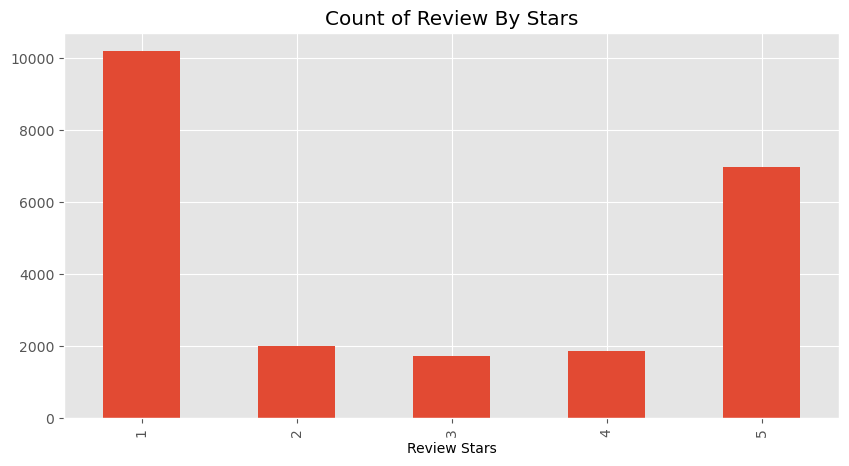

In [6]:
ax = df2['score'].value_counts().sort_index().plot(kind='bar',
                                             title = 'Count of Review By Stars',
                                             figsize = (10,5))
ax.set_xlabel('Review Stars')
plt.show()

# NLTK Tools

In [7]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [9]:
def sent(row):
  # Detect language of each row
    snt = sia.polarity_scores(row)
  # Extract the language from dict
    x = dict(list(snt.items())[3:])
    for k, v in x.items():
        x[k] = float(v)
        return x[k]

In [10]:
# Train 70%, Validation 15%, Test Split 15% 
from sklearn.model_selection import train_test_split as tts
Train, Test = tts(df2, train_size = 0.7, random_state =123)
Valid, Test = tts(Test, train_size = 0.5, random_state =123)

In [17]:
df2['VADER_score'] = df2['content'].apply(sent)
Train['VADER_score'] = Train['content'].apply(sent)
Test['VADER_score'] = Test['content'].apply(sent)
Valid['VADER_score'] = Valid['content'].apply(sent)

C:\Users\User\AppData\Local\Temp\ipykernel_22640\4258517058.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['VADER_score'] = df2['content'].apply(sent)


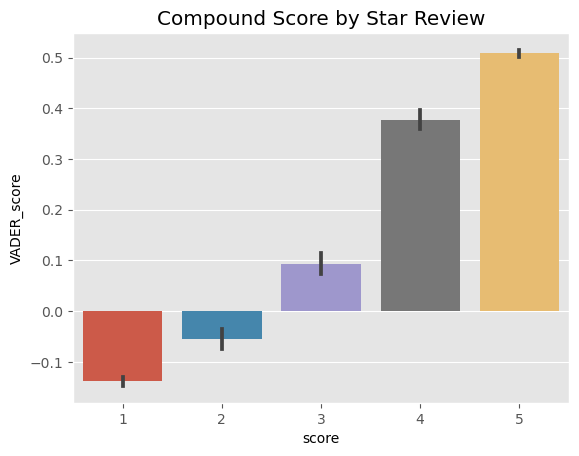

In [18]:
# Compound Score by Star Review (Overall dataset)
ax = sns.barplot(data = df2, x = 'score', y = 'VADER_score')
ax.set_title('Compound Score by Star Review')
plt.show()

In [19]:
def lblconvert(x):
    sent = None 
    if x > 0.049:
        sent = "positive"
    elif x < -0.049:
        sent = "negative"
    else:
        sent = "neutral"
    return sent

In [20]:
df2['VADER_lbl'] = df2['VADER_score'].apply(lblconvert)
Train['VADER_lbl'] = Train['VADER_score'].apply(lblconvert)
Valid['VADER_lbl'] = Valid['VADER_score'].apply(lblconvert)
Test['VADER_lbl'] = Test['VADER_score'].apply(lblconvert)

C:\Users\User\AppData\Local\Temp\ipykernel_22640\2033925764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['VADER_lbl'] = df2['VADER_score'].apply(lblconvert)


In [21]:
Test

,content,act_label,score,lang,VADER_score,VADER_lbl
524,very less things for free even not a movie,negative,1,en,0.4654,positive
27855,why to buy prime if u have to buy movies again...,negative,1,en,-0.4215,negative
10479,dave filoni continues the star wars adventures...,positive,5,en,0.4404,positive
6583,i have facing the problem while using the netf...,negative,1,en,-0.8047,negative
17965,doesnt work with dex on android please update ...,neutral,3,en,0.6369,positive
...,...,...,...,...,...,...
14753,horrible downgrade in every way from hbo max i...,negative,1,en,-0.5595,negative
20291,lmao pretty nice app 4 stars because it can ru...,positive,4,en,0.9081,positive
17369,since downloading max the video player info pa...,negative,2,en,-0.2812,negative
15348,im loving this app its worth the price,positive,5,en,0.7003,positive


In [22]:
from textblob import TextBlob

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getAnalysis(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'


In [23]:
df2['TextBlob_score'] = df2['content'].apply(getPolarity)
df2['TextBlob_lbl'] = df2['TextBlob_score'].apply(getAnalysis)
Train['TextBlob_score'] = Train['content'].apply(getPolarity)
Train['TextBlob_lbl'] = Train['TextBlob_score'].apply(getAnalysis)
Valid['TextBlob_score'] = Valid['content'].apply(getPolarity)
Valid['TextBlob_lbl'] = Valid['TextBlob_score'].apply(getAnalysis)
Test['TextBlob_score'] = Test['content'].apply(getPolarity)
Test['TextBlob_lbl'] = Test['TextBlob_score'].apply(getAnalysis)

C:\Users\User\AppData\Local\Temp\ipykernel_22640\413349416.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['TextBlob_score'] = df2['content'].apply(getPolarity)
C:\Users\User\AppData\Local\Temp\ipykernel_22640\413349416.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['TextBlob_lbl'] = df2['TextBlob_score'].apply(getAnalysis)


In [24]:
Train

,content,act_label,score,lang,VADER_score,VADER_lbl,TextBlob_score,TextBlob_lbl
15644,app keeps closing on my phone it says it has a...,neutral,3,en,0.7684,positive,1.000000,positive
10698,this app wont run on either my android phone o...,negative,1,en,0.2732,positive,0.210317,positive
4733,the bessst,positive,5,en,0.0000,neutral,0.000000,neutral
1228,its a very fraud app please dont download,negative,1,en,-0.3673,negative,0.200000,positive
12955,its good if you want to watch star wars and ot...,positive,5,en,-0.1027,negative,0.287500,positive
...,...,...,...,...,...,...,...,...
18869,it doesnt perform as seamlessly as former app ...,positive,4,en,0.6908,positive,-0.104167,negative
26523,all the best shows at my fingertips,positive,5,en,0.6369,positive,1.000000,positive
21501,good,positive,4,so,0.4404,positive,0.700000,positive
19241,would be a whole lot better if they would cont...,positive,4,en,0.9371,positive,0.142857,positive


In [27]:
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
plt.style.use('fivethirtyeight')

In [29]:
labels = df2['VADER_lbl'].unique()
labels

array(['negative', 'positive', 'neutral'], dtype=object)

# VADER Results

In [30]:
cm1 = confusion_matrix(Train['act_label'],Train['VADER_lbl'], labels = labels)
cm3 = confusion_matrix(Test['act_label'],Test['VADER_lbl'], labels = labels)
cm2 = confusion_matrix(Valid['act_label'],Valid['VADER_lbl'], labels = labels)

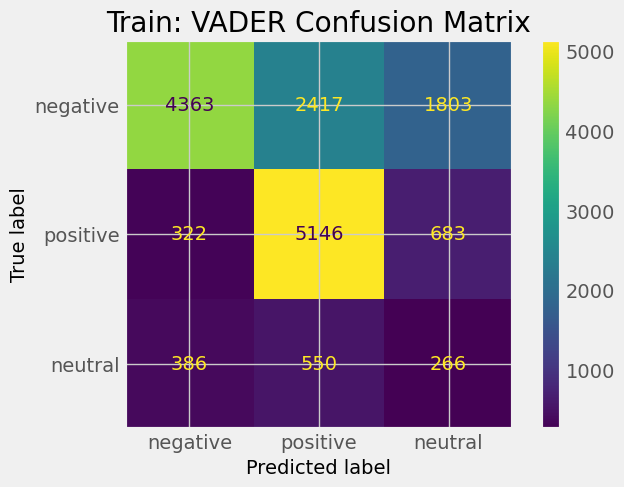

In [31]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm1,
                              display_labels=labels)
disp.plot()
plt.title('Train: VADER Confusion Matrix')
plt.show()

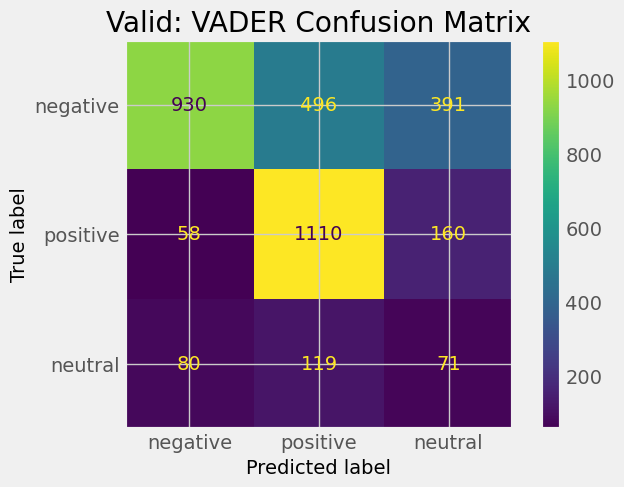

In [32]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm2,
                              display_labels=labels)
disp.plot()
plt.title('Valid: VADER Confusion Matrix')
plt.show()

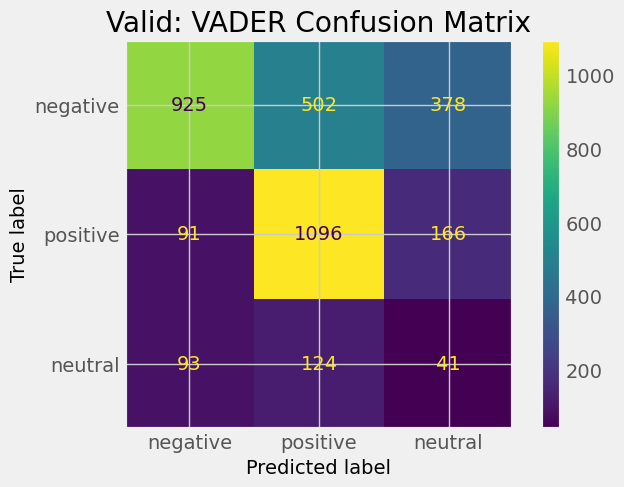

In [34]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm3,
                              display_labels=labels)
disp.plot()
plt.title('Valid: VADER Confusion Matrix')
plt.show()

In [35]:
Trainvader_bac = balanced_accuracy_score(Train['act_label'],Train['VADER_lbl'])
Trainvader_f1 = f1_score(Train['act_label'],Train['VADER_lbl'],average = 'weighted' )
Trainvader_recall = recall_score(Train['act_label'],Train['VADER_lbl'],average = 'weighted')
Trainvader_precision = precision_score(Train['act_label'],Train['VADER_lbl'],average = 'weighted')
print('Train VADER Metrics')
print("Accuracy:", Trainvader_bac)
print("F1-Score:",Trainvader_f1)
print("Recall:", Trainvader_recall)
print("Precision:", Trainvader_precision)


Train VADER Metrics
Accuracy: 0.5220800635187718
F1-Score: 0.6328515942172138
Recall: 0.6133910642570282
Precision: 0.7155099785678909


In [37]:
Validvader_bac = balanced_accuracy_score(Valid['act_label'],Valid['VADER_lbl'])
Validvader_f1 = f1_score(Valid['act_label'],Valid['VADER_lbl'],average = 'weighted' )
Validvader_recall = recall_score(Valid['act_label'],Valid['VADER_lbl'],average = 'weighted')
Validvader_precision = precision_score(Valid['act_label'],Valid['VADER_lbl'],average = 'weighted')
print('Valid VADER Metrics')
print("Accuracy:", Validvader_bac)
print("F1-Score:",Validvader_f1)
print("Recall:", Validvader_recall)
print("Precision:", Validvader_precision)

Valid VADER Metrics
Accuracy: 0.5368796759020836
F1-Score: 0.6383857911010928
Recall: 0.6181551976573938
Precision: 0.7225704735723855


In [47]:
Testvader_bac = balanced_accuracy_score(Test['act_label'],Test['VADER_lbl'])
Testvader_f1 = f1_score(Test['act_label'],Test['VADER_lbl'],average = 'weighted' )
Testvader_recall = recall_score(Test['act_label'],Test['VADER_lbl'],average = 'weighted')
Testvader_precision = precision_score(Test['act_label'],Test['VADER_lbl'],average = 'weighted')
print('Test VADER Metrics')
print("Accuracy:", Testvader_bac)
print("F1-Score:",Testvader_f1)
print("Recall:", Testvader_recall)
print("Precision:", Testvader_precision)

Test VADER Metrics
Accuracy: 0.4938106131747982
F1-Score: 0.6251491540558624
Recall: 0.6036299765807962
Precision: 0.6981112125623289


# TextBlob Results

In [39]:
cm4 = confusion_matrix(Train['act_label'],Train['TextBlob_lbl'], labels = labels)
cm5 = confusion_matrix(Valid['act_label'],Valid['TextBlob_lbl'], labels = labels)
cm6 = confusion_matrix(Test['act_label'],Test['TextBlob_lbl'], labels = labels)

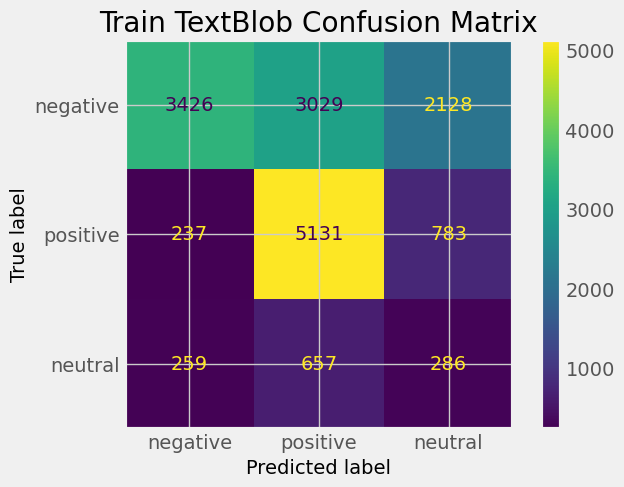

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm4,
                              display_labels=labels)
disp.plot()
plt.title('Train TextBlob Confusion Matrix')
plt.show()

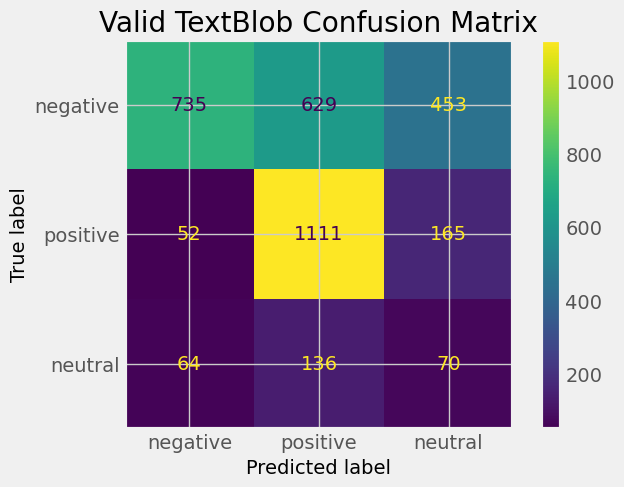

In [41]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm5,
                              display_labels=labels)
disp.plot()
plt.title('Valid TextBlob Confusion Matrix')
plt.show()

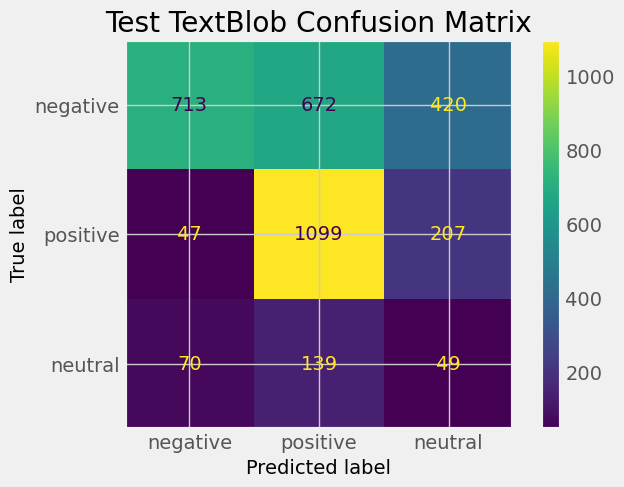

In [42]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm6,
                              display_labels=labels)
disp.plot()
plt.title('Test TextBlob Confusion Matrix')
plt.show()

In [44]:
Traintextb_bac = balanced_accuracy_score(Train['act_label'],Train['TextBlob_lbl'])
Traintextb_f1 = f1_score(Train['act_label'],Train['TextBlob_lbl'],average = 'weighted' )
Traintextb_recall = recall_score(Train['act_label'],Train['TextBlob_lbl'], average = 'weighted')
Traintextb_precision = precision_score(Train['act_label'],Train['TextBlob_lbl'], average = 'weighted')
print('Train TextBlob Metrics')
print("Accuracy:", Traintextb_bac)
print("F1-Score:",Traintextb_f1)
print("Recall:", Traintextb_recall)
print("Precision:", Traintextb_precision)

Train TextBlob Metrics
Accuracy: 0.49042373655712884
F1-Score: 0.5695514699998888
Recall: 0.5549071285140562
Precision: 0.7018454122978002


In [45]:
Validtextb_bac = balanced_accuracy_score(Valid['act_label'],Valid['TextBlob_lbl'])
Validtextb_f1 = f1_score(Valid['act_label'],Valid['TextBlob_lbl'],average = 'weighted' )
Validtextb_recall = recall_score(Valid['act_label'],Valid['TextBlob_lbl'], average = 'weighted')
Validtextb_precision = precision_score(Valid['act_label'],Valid['TextBlob_lbl'], average = 'weighted')
print('Valid TextBlob Metrics')
print("Accuracy:", Validtextb_bac)
print("F1-Score:",Validtextb_f1)
print("Recall:", Validtextb_recall)
print("Precision:", Validtextb_precision)

Valid TextBlob Metrics
Accuracy: 0.5001228594027141
F1-Score: 0.5743943392942108
Recall: 0.5610541727672035
Precision: 0.6978799629048928


In [46]:
Testtextb_bac = balanced_accuracy_score(Test['act_label'],Test['TextBlob_lbl'])
Testtextb_f1 = f1_score(Test['act_label'],Test['TextBlob_lbl'],average = 'weighted' )
Testtextb_recall = recall_score(Test['act_label'],Test['TextBlob_lbl'], average = 'weighted')
Testtextb_precision = precision_score(Test['act_label'],Test['TextBlob_lbl'], average = 'weighted')
print('Test TextBlob Metrics')
print("Accuracy:", Testtextb_bac)
print("F1-Score:",Testtextb_f1)
print("Recall:", Testtextb_recall)
print("Precision:", Testtextb_precision)

Test TextBlob Metrics
Accuracy: 0.4657351209389648
F1-Score: 0.5606829350305245
Recall: 0.5447892271662763
Precision: 0.6872856285475178


In [70]:
df2.to_csv('VADER and TextBlob sent.csv')
